In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def read(myname):
    df=pd.read_parquet(myname, engine='pyarrow')
    df['timestamp']=pd.to_datetime(df['exch_ts'], unit='ns')
    df.set_index('timestamp', inplace=True)
    return df

In [58]:
def get_price(df,myside):
    price = df[df['side'] == myside]['price'].resample('1S').mean()
    return price.interpolate()

In [59]:
def get_stats(df,need_spread):
    dfNew=pd.DataFrame(columns=['b_price','s_price'])
    dfNew['b_price']=get_price(df,1)
    dfNew['s_price']=get_price(df,-1)
    dfNew['middle_price']=(dfNew['b_price']+dfNew['s_price'])/2
    if (need_spread):
        dfNew['spread']=2*(dfNew['b_price']-dfNew['s_price'])/(dfNew['b_price']+dfNew['s_price'])*10000
    return dfNew

In [66]:
df_spt=read("trades_spt.parquet")
df_spt=get_stats(df_spt,1)
df_spt.head(5)

,b_price,s_price,middle_price,spread
timestamp,,,,
2021-04-01 00:00:00,1919.380000,1919.370000,1919.375000,0.052100
2021-04-01 00:00:01,1919.761481,1919.564000,1919.662741,1.028730
2021-04-01 00:00:02,1920.165392,1920.127778,1920.146585,0.195893
2021-04-01 00:00:03,1920.787143,1920.529231,1920.658187,1.342832
2021-04-01 00:00:04,1921.356957,1921.713889,1921.535423,-1.857537


In [62]:
df_fut=read("trades_fut.parquet")
df_fut=get_stats(df_fut,0)
df_fut.bfill(inplace=True)
df_fut=df_fut.iloc[1:,:]
df_fut.head(5)

,b_price,s_price,middle_price
timestamp,,,
2021-04-01 00:00:00,1923.070000,1922.937021,1923.317164
2021-04-01 00:00:01,1923.697308,1922.937021,1923.317164
2021-04-01 00:00:02,1924.261322,1923.828214,1924.044768
2021-04-01 00:00:03,1924.298704,1924.185909,1924.242306
2021-04-01 00:00:04,1925.243898,1925.246364,1925.245131


In [87]:
a=0
df_spt['here_SpreadGreater']=(df_spt['spread']>=a).astype(int)
df_spt['here_FutGreater']=(df_fut['middle_price']>df_spt['middle_price']).astype(int)
df_spt['here_buy']=df_spt['here_SpreadGreater']*df_spt['here_FutGreater']
df_spt['here_sell']=(df_spt['here_SpreadGreater'])*(1-df_spt['here_FutGreater'])
df_spt.head(5)

,b_price,s_price,middle_price,spread,here_SpreadGreater,here_FutGreater,here_sell,here_buy
timestamp,,,,,,,,
2021-04-01 00:00:00,1919.380000,1919.370000,1919.375000,0.052100,1,1,0,1
2021-04-01 00:00:01,1919.761481,1919.564000,1919.662741,1.028730,1,1,0,1
2021-04-01 00:00:02,1920.165392,1920.127778,1920.146585,0.195893,1,1,0,1
2021-04-01 00:00:03,1920.787143,1920.529231,1920.658187,1.342832,1,1,0,1
2021-04-01 00:00:04,1921.356957,1921.713889,1921.535423,-1.857537,0,1,0,0


62698


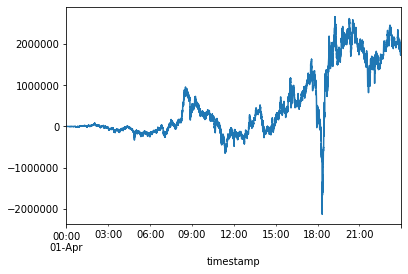

In [89]:
trajectory_loss=(df_spt['here_buy']*df_spt['b_price']).cumsum()
trajectory_profit=(df_spt['here_sell']*df_spt['s_price']).cumsum()
trajectory_tek_amt=(df_spt['here_buy']-df_spt['here_sell']).cumsum()
trajectory_middle_price=(df_spt['s_price']+df_spt['b_price'])/2
trajectory_pnl=trajectory_profit-trajectory_loss+trajectory_tek_amt*trajectory_middle_price
print(trajectory_tek_amt.values[-1])
trajectory_pnl.plot()

In [82]:
def get_pnl(df_spt,df_fut,a):
    df_spt['here_SpreadGreater']=(df_spt['spread']>=a).astype(int)
    df_spt['here_FutGreater']=(df_fut['middle_price']>df_spt['middle_price']).astype(int)
    df_spt['here_buy']=df_spt['here_SpreadGreater']*df_spt['here_FutGreater']
    df_spt['here_sell']=(df_spt['here_SpreadGreater'])*(1-df_spt['here_FutGreater'])
    
    trajectory_loss=(df_spt['here_buy']*df_spt['b_price']).cumsum()
    trajectory_profit=(df_spt['here_sell']*df_spt['s_price']).cumsum()
    trajectory_tek_amt=(df_spt['here_buy']-df_spt['here_sell']).cumsum()
    trajectory_middle_price=(df_spt['s_price']+df_spt['b_price'])/2
    trajectory_pnl=trajectory_profit-trajectory_loss+trajectory_tek_amt*trajectory_middle_price
    return trajectory_pnl.values[-1]

In [86]:
for a in np.linspace(0,10,20,endpoint=False):
    print(a,get_pnl(df_spt,df_fut,a))

0.0 1801971.2999056876
0.5 609717.4428188354
1.0 265259.88334706426
1.5 108274.8662427757
2.0 41005.92830821592
2.5 16839.691447823774
3.0 7916.734161875211
3.5 4065.8006237918744
4.0 2118.686448769993
4.5 1063.6957166713692
5.0 884.2076741130222
5.5 603.9484775409874
6.0 332.8583242847617
6.5 218.06299473364743
7.0 218.06299473364743
7.5 252.35455788064428
8.0 252.35455788064428
8.5 187.65089846035244
9.0 147.00107548971482
9.5 88.6495754897146


In [101]:
def get_covar(x):
    sdvig_fut=df_fut['middle_price'].diff()
    sdvig_spt=df_spt['middle_price'].diff()
    return (sdvig_fut[x:]*sdvig_spt[-x:]).sum()

In [127]:
for x in range(10):
    print(x,get_covar(x))

0 2905.5922493478915
1 -0.00021854166667219032
2 0.010638595328307054
3 0.05816881042582882
4 0.8190059929655091
5 0.8458425670396091
6 0.8458425670396073
7 0.8461259003729412
8 0.8461259003729527
9 0.8446241642618435


In [155]:
%time
mas = np.vectorize(get_covar)(np.arange(49*len(sdvig_fut)//100, 51*len(sdvig_fut)//100))

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 14.1 µs


In [121]:
%time
mm=list(map(lambda x:get_covar(x), np.arange(len(sdvig_fut)//100)))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


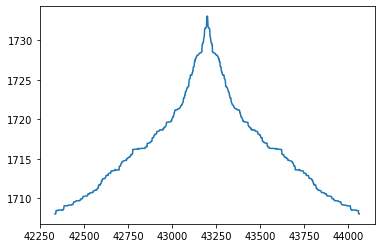

In [156]:
plt.plot(np.arange(49*len(sdvig_fut)//100, 51*len(sdvig_fut)//100),mas)